<a href="https://colab.research.google.com/github/poudyaldiksha/Data-Science-project/blob/main/Lesson_43_b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 43: Ordinary Least Square Method,Multicollinearity, VIF

Recap

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = '/content/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

#### Activity 1: Multiple Linear Regression

In multiple linear regression, you have more than one feature to predict the target.

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_n x_n + \epsilon$$

where

- $x_1, x_2, x_3, \dots , x_n$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value

In this case, to predict relative humidity (the target to be predicted), we will consider all the features except for `'DateTime'` because it is not a numeric value. So the above regression equation becomes

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

For illustration, consider only three features that are $\text{CO}, \text{T}$ and $\text{AH}$ and coefficients 14, 2, -3 and 5. So the above equation becomes
$$y = 14 + 2 x_1 -3 x_2 + 5 x_3$$

or
$$\text{RH} = 14 + 2\text{CO} -3 \text{T} + 5 \text{AH}$$

So when

- all three parameters are $0$, then the relative humidity will always be $14$

- all three parameters are $1$, then the relative humidity is $14 + 2 - 3 + 5 = 18$

Similarly, you can simulate all the possible cases for the above three parameters in the illustration.

Now, you may not require all the 11 features to predict relative humidity values. You may have to eliminate a few of the above features. Soon you will get to know why.

So our next task is to estimate the values of the coefficients


 The linear regression equation considered is

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

In this activity, we will estimate the values of these coefficients and find out which columns are least significant by referring to their p-values.



#### Activity 2: Multiple Linear Regression Model Using `sklearn` Module

Let's jump right ahead to build a multiple linear regression model using the `sklearn` module. Later, we will also use the `statsmodels` module to build a linear regression model and also to assess whether a feature is useful or in technical terms **significant**.

You will understand this as we progress. For the time being, let's first create a list of features.

In [ ]:
#  Create a list of feature variables.
features = list(df.columns.values[1:-1])
features.remove('RH')
features

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'AH',
 'Year',
 'Month',
 'Day']

Now let's build a linear regression model using the `sklearn` module by including all the features listed above.

In [ ]:
#  Build a linear regression model using the sklearn module by including all the features listed above.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:13])
features.remove("RH")

X = df[features]
y = df['RH']

# Splitting the DataFrame into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}")

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}")


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


As you can see, the coefficients for a few of the features have a very low value and the intercept ($\beta_0$) is very high in comparison. We will analyse the significance of these values as we proceed forward. For the time being, let's compute the $R^2$, MSE, RMSE and MAE values.

In [ ]:
#  Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


When we built the linear regression model with only the temperature as the independent variable, the $R^2$ value was 32.46% approximately. Now it has increased to 87.9% because of having more features which is a great improvement as the $R^2$ value should be close to 1. This means the unexplained variance in the regression model is only 12.1%. The MSE, RMSE and MAE values are also not too high.

So by looking at these metrics, we may tend to think that we have built a very good model but how do we make sure. For this, we need to measure the significance of the coefficients of all the features including the constant as well. This is the point where we will use the `statsmodels.api` module in Python.

---

#### Activity 3: The `statsmodels.api` Module

The `statsmodels` module is another Python module that you can use to build a linear regression model and also assess whether a feature is useful or in technical terms **significant**.

Let's create data frames for the features and target again and also split them into train and test sets.

In [ ]:
#  Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

Now to build a linear regression model

- Import the `statsmodels.api` module.

- Call the `add_constant()` function of `statsmodels.api` module. It takes the feature set as an input. It initialises the $\beta_0$ (or constant) with some arbitrary value and then seeks the best value for it through the **ordinary least squares** method which we shall discuss later.

- Create an object of the `OLS` class and call the `fit()` function to build a linear regression model. The constructor of the `OLS` class takes the target and features as inputs (in that order) and builds a linear regression model.

- Finally, use the `params` attribute of the `OLS` class to get the values of all the coefficients.

In [ ]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
sm_lin_reg = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
sm_lin_reg.params

,0
const,-15028.451823
PT08.S1(CO),0.014833
C6H6(GT),-0.903464
PT08.S2(NMHC),-0.005881
PT08.S3(NOx),0.001503
PT08.S4(NO2),0.026497
PT08.S5(O3),-0.001066
T,-2.354919
AH,29.551742
Year,7.505153


The above values for the constant and the coefficients of all the features are almost the same as the ones obtained through the `sklearn` linear regression model.

In [ ]:
# Subtract the constant and the coefficient values obtained through 'sklearn' from the ones obtained through 'statsmodels.api'.
print(sm_lin_reg.params.values[0] - sklearn_lin_reg.intercept_[0])
print(sm_lin_reg.params.values[1:] - sklearn_lin_reg.coef_)

As you can see the above values are practically $0$ because their scale is at least $10^{-11}$ or $\frac{1}{10^{11}}$

Now let's print the statistical summary of the regression model that we built to find the significant features based on **p-value**.

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(sm_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:46:25   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

For a feature to be statistically significant, the p-value should be equal to or less than 0.05. From the above table, `PT08.S3(NOx)` and `PT08.S5(O3)` have the p-values greater than 0.05. Hence, they are statistically insignificant for the regression model created. So you may have to eliminate these features.

Also, read the second warning obtained in the summary. It says `The condition number is large, 5.25e+07. This might indicate that there are strong multicollinearity or other numerical problems.`

So now it is the time to understand three important concepts to make sense of what we have done so far and what the results and the warnings mean. These concepts are:

1. Ordinary Least Squares (OLS)
2. Multicollinearity
3. p-value



#### Activity 4: Ordinary Least Squares (OLS)

Consider the regression equation

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_k x_k + \epsilon$$

where

- $x_1, x_2, x_3, \dots , x_k$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value which follows normal distribution with mean $0$ and some standard deviation of $\sigma$


The parameters $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ and $\sigma$ are assumed to be unknown and must be estimated from the data, which we shall suppose will consist of the values of $Y_1, Y_2, Y_3, \dots , Y_n$ where $Y_i$ is the response level corresponding to the $k$ features $x_{i1}, \dots , x_{i2}, \dots , x_{ik}$ . That is, the $Y_i$ are related to these features through

$$E[Y_i] = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \dots + \beta_k x_{ik}$$

where

- $E[Y_i]$ means **expected value** for an instance $i$. In simple terms, instance or $i$ denotes a row in a data frame

- $x_{i1}$ denotes item at the $i^{\text{th}}$ row in the $1^{\text{st}}$ column in a data frame having only features

- $x_{i2}$ denotes item at the $i^{\text{th}}$ row in the $2^{\text{nd}}$ column in a data frame having only features

- $x_{i3}$ denotes item at the $i^{\text{th}}$ row in the $3^{\text{rd}}$ column in a data frame having only features

  $\dots$

- $x_{ik}$ denotes item at the $i^{\text{th}}$ row in the $k^{\text{th}}$ column in a data frame having only features

For e.g., in the `X` DataFrame there are $9357$ rows. So let $x_1, x_2, x_3, \dots , x_{11}$ denote $\text{CO}, \text{C}_6 \text{H}_6, \text{NMHC}, \dots, \text{day}$ respectively.

Now let's display the first-three and last-three rows of the features.


In [ ]:
#  Display the first-three rows.
df.head(3)

,DateTime,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Day,Day Name
0,2004-03-10 18:00:00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,2004,3,10,Wednesday
1,2004-03-10 19:00:00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,2004,3,10,Wednesday
2,2004-03-10 20:00:00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,2004,3,10,Wednesday


In [ ]:
# Display the last-three rows.
df.tail(3)

So $E[Y_1]$ denotes the predicted value for the first row values in the `X` DataFrame containing features i.e.

$$E[Y_1] = \beta_0 + \beta_1 \times 1360.0 + \beta_2 \times 11.9 + \beta_3 \times 1046.0 + \dots + \beta_{11} \times 10$$

Similarly,

$$E[Y_2] = \beta_0 + \beta_1 \times 1292.0 + \beta_2 \times 9.4 + \beta_3 \times 955.0 + \dots + \beta_{11} \times 10$$

$$E[Y_3] = \beta_0 + \beta_1 \times 1402.0 + \beta_2 \times 9.0 + \beta_3 \times 939.0 + \dots + \beta_{11} \times 10$$

$$\vdots$$

$$E[Y_{9357}] = \beta_0 + \beta_1 \times 1071.0 + \beta_2 \times 11.9 + \beta_3 \times 1047.0 + \dots + \beta_{11} \times 4$$

*There are a total of 9357 rows in the dataset.*

As we said earlier, the difference between the actual and the predicted values should be 0 or close to 0 for an accurate prediction model i.e.

$$Y_1 - E[Y_1] \approx 0$$

$$Y_2 - E[Y_2] \approx 0$$

$$Y_3 - E[Y_3] \approx 0$$

$$\vdots$$

$$Y_N - E[Y_N] \approx 0$$

where $N$ is the total number of instances (or rows in a data frame).

**The OLS says that the sum of squares of all these errors i.e.**

$$J = (Y_1 - E[Y_1])^2 + (Y_2 - E[Y_2])^2 + (Y_3 - E[Y_3])^2 + \dots + (Y_N - E[Y_N])^2$$

**should be the least or minimum.**

The above expression can be compressed as
$$J = \sum_{i = 1}^{N}(Y_i - E[Y_i])^2$$

So in general, it can be written as

$$J(\beta, x) = \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})^2 $$

where $J(\beta, x)$ denotes the sum of the squared errors is dependent on the coefficients ($\beta_0, \beta_1, \beta_2, \dots, \beta_k$) and features ($x_1, x_2, x_3, \dots , x_k$)


**Note:** Beyond this point, we should know calculus to understand the subsequent points discussed.

The above function represents a three-dimensional curve similar to the one shown in the image below.

<center><img src = 'https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/14498/versions/1/screenshot.jpg' width = 800></center>

**Image credits:** *https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/14498/versions/1/screenshot.jpg*

To find the points of maxima (peak) or minima (valley), we differentiate a mathematical function w.r.t. independent variable and equate the result obtained to 0 because the slope of a curve at the point of maxima (peak) or minima (valley) is 0. Differentiation (or derivative) represents slope at a point.

In the above equation, all the $x$ quantities are known quantities as we have seen earlier. So the $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are unknown quantities. Thus, they are independent variables.

Here $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are independent of each other. Hence, we can do partial differentiation w.r.t. to each of the betas independently.

Let's differentiate $J(\beta, x)$ w.r.t. $\beta_0$. So every other term apart from $\beta_0$ will be treated as a constant. And the differentiation (or derivative) of a constant is 0.

$$\frac{\partial J}{\partial \beta_0} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-1) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik}) = 0$$

Similarly,

$$\frac{\partial J}{\partial \beta_1} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{i1}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i1} = 0$$

$$\frac{\partial J}{\partial \beta_2} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{i2}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i2} = 0$$

$$\vdots$$

$$\frac{\partial J}{\partial \beta_k} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-x_{ik}) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{ik} = 0$$


On further reducing the above $k + 1$ equations, we get

$$\sum_{i = 1}^{N}Y_i = N \beta_0 + \beta_1 \sum_{i = 1}^{N}x_{i1} + \beta_2 \sum_{i = 1}^{N}x_{i2} +  \dots + \beta_k \sum_{i = 1}^{N} x_{ik}$$

$$\sum_{i = 1}^{N}Y_i x_{i1} = \beta_0 \sum_{i = 1}^{N}x_{i1} + \beta_1 \sum_{i = 1}^{N}x_{i1}^2 + \beta_2 \sum_{i = 1}^{N} x_{i1} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{i1} x_{ik}$$

$$\vdots$$

$$\sum_{i = 1}^{N}Y_i x_{ik} = \beta_0 \sum_{i = 1}^{N}x_{ik} + \beta_1 \sum_{i = 1}^{N} x_{ik} x_{i1} + \beta_2 \sum_{i = 1}^{N} x_{ik} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}^2$$


Now we have $k + 1$ linear equations having $k + 1$ unknowns i.e. $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ . By solving these $k + 1$ equations, we can get the beta values. This is exactly the same as solving two linear equations having two unknowns. For e.g., the solution to the two linear equations

$$8\beta_0 + 7\beta_1 = 38 \space{} \text{and} \space{} 3 \beta_0 - 5 \beta_1 = -1$$

is
$$\beta_0 = 3 \space{} \text{and} \space{} \beta_1 = 2$$

So all-in-all, **ordinary least  squares** says that **find the values of the coefficients ($\beta_0, \beta_1, \beta_2, \dots, \beta_k$) such that the sum of the squares of differences between the actual values and the predicted values is minimum.**

To solve $k + 1$ linear equations having $k + 1$ unknowns, you need to know matrices.

---

#### Activity 5: Multicollinearity

Now let's learn a new important concept called multicollinearity which is critical to multiple linear regression. But before that, let's print the statistical summary of the multiple linear regression model that we built earlier.

In [ ]:
#Print the summary of the multiple linear regression model built earlier.
print(sm_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:10:13   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

You can see two warning messages in the output at the end of the summary table. The second warning says `The condition number is large, 5.25e+07. This might indicate that there are strong multicollinearity or other numerical problems.`

Now, let's find out what multicollinearity is and why is it important?

Multicollinearity is a situation where the independent variables or features are correlated to each other. Ideally, only the dependent variable (or target) should be correlated with the independent variables and the independent variables should not be correlated with each other at all.

Let's create a heatmap of a correlation DataFrame of the Air quality analysis dataset to understand this concept better.


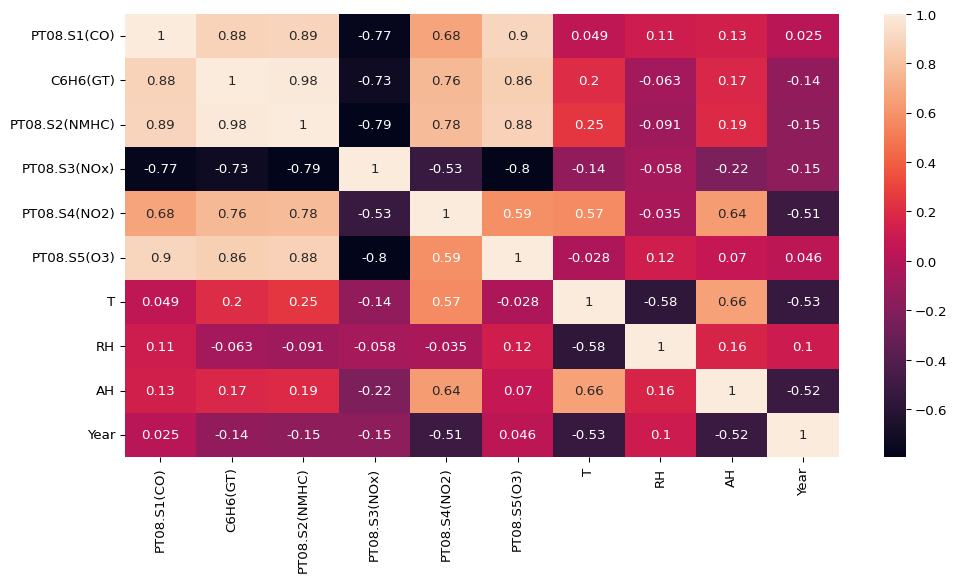

In [ ]:
# create a heatmap of a correlation DataFrame of the air quality analysis dataset
plt.figure(figsize = (12, 6), dpi = 96)
sns.heatmap(df.iloc[:,1:-3].corr(), annot = True)
plt.show()

From the heatmap, you can see that, the dependent variable `RH` is moderately correlated with `T` and weakly correlated with carbon monoxide (`'PT08.S1(CO)'`), ozone (`'PT08.S5(O3)'`) , absolute humidity (`AH`) and year (`Year`).

Ideally, to build a multiple linear regression model to predict relative humidity, we should have considered carbon monoxide, ozone, absolute humidity and year independent variables only instead of considering all the independent variables. But among these 4 features:

- carbon monoxide and ozone are strongly correlated to each other.

- temperature and absolute humidity are moderately correlated to each other.

- temperature and year are moderately correlated to each other.

- absolute humidity and year are moderately correlated to each other.

The above four cases are examples of multicollinearity wherein the independent variables are correlated to each other.

Let's create a correlation heatmap again between the above four features and the dependent variable.

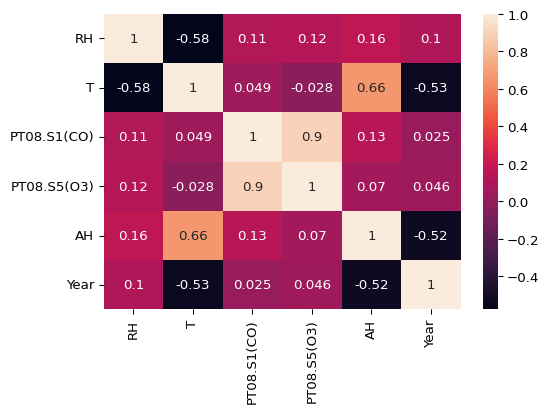

In [ ]:
# Create a correlation heatmap between 'RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year' variables.
plt.figure(figsize = (6, 4), dpi = 96)
sns.heatmap(df[['RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year']].corr(), annot = True)
plt.show()

This multicollinearity causes redundancy because of which we cannot say for sure which of the independent variables are actually contributing to the prediction of the dependent variable.

In this case, to remove multicollinearity,

- Choose either `T` or `AH` as one of the independent variables. Since the correlation between `RH` and `T` is stronger compared to the correlation between `RH` and `AH`, let's choose `T`.

- Choose either `'PT08.S1(CO)'` or `'PT08.S5(O3)'` as one of the independent variables. Since the correlation between `RH` and `PT08.S5(O3)` is stronger compared to the correlation between `RH` and `'PT08.S1(CO)'`, let's choose `PT08.S5(O3)`.

- Drop `Year` as it is moderately correlated with `'T'`.

Let's create a correlation heatmap again to verify whether the multicollinearity is eliminated or not.

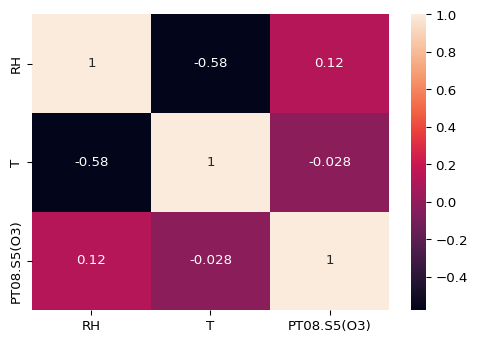

In [ ]:
#  Create a correlation heatmap between 'RH', 'T', 'PT08.S5(O3)' variables.
plt.figure(figsize = (6, 4), dpi = 96)
sns.heatmap(df[['RH', 'T', 'PT08.S5(O3)']].corr(), annot = True)
plt.show()

Now that we have removed multicollinearity and selected the features that are likely to contribute best to the prediction of relative humidity values, let's build a linear regression model again using the `statsmodels.api` module.

In [ ]:
#  Build a linear regression model again with 'T' and 'PT08.S5(O3)' as independent variables to predict 'RH'.
X_train = X_train[['T', 'PT08.S5(O3)']]
X_test = X_test[['T', 'PT08.S5(O3)']]

# Add a constant to get an intercept
X_train_sm1 = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr1 = sm.OLS(y_train, X_train_sm1).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr1.params

,0
const,64.956429
T,-1.104251
PT08.S5(O3),0.004509


Let's now print the summary table as well.

In [ ]:
#Print the summary table to get all the parameters for the features used to build a linear regression model.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:16:00   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

So even after removing multicollinearity, we are getting the same warning again.

 In the next activity, we learn how to measure multicollinearity and how much of it is tolerable.

You will learn how to measure the extent of multicollinearity in a multiple linear regression model by calculating the **variance inflation factor** values for each independent variable. This exercise will enable you to select the features (or independent variables) that predicts the values of the dependent variable best. In machine learning discourse, this exercise is called **feature selection** or **feature elimination**.

 VIF is one of the ways to select or eliminate features to build a good linear regression model.


---

* Sometimes two or more variables are correlated to a independant variable which is hard to identify from correlation plot. in that case you can check the VIF (Variance Inflation Factor).

**What's the Variance Inflation Factor (VIF)?**

VIF value ranges between 1 to infinity .
value 1 indicate, no multicollinearity and higher the value of VIF then higher the value of multicollinearity.


#### Activity 3: Variance Inflation Factor Math

Variance Infation Factor (VIF) is a way to detect multicollinearity between independent variables in a dataset. We calculate the VIF values to measure the extent of multicollinearity between the independent variables.  

For $k$ different independent variables, we can calculate $k$ different VIFs (one for each $x_i$ where $i = 1, 2, 3, \dots, k$) in three steps:

**Step one**

First, build a multiple linear regression model wherein $x_i$ is a target variable and it is a function of all the other feature variables as illustrated in the equation below.

$$x_1 = \beta_0^* + \beta_2^* x_2 + \beta_3^* x_3 + \beta_4^* x_4 + \dots + \beta_k^* x_k + \epsilon^*$$

Here,

- $x_1$ is a feature acting as the target (or dependent) variable in above equation

- $x_2, x_3, x_4, \dots , x_k$ are independent variables or features

- $\beta_0^*, \beta_2^*, \beta_3^*, \dots, \beta_k^*$ are the corresponding regression coefficients of the independent variables in the above linear regression equation

- **$\epsilon^*$** is the random error obtained along with the predicted value

**Step two**

Then, calculate the VIF for $x_{i}$ using the following formula:

$$\text{VIF}_{i} = \frac{1}{1-R_{i}^{2}}$$

where $R^2 _i$ is the coefficient of determination of the regression equation in step one, with $x_{1}$ on the left hand side, and all other independent variables on the right hand side.

**Step three**

Analyse the extent of multicollinearity by considering the magnitude of the $\text{VIF}_{i}$. **A rule of thumb is that if $\text{VIF}_{i} > 10$, then multicollinearity is high. In that case, the $x_i$ feature must be dropped to predict the values of the target (or dependent) variable.** A cutoff of 5 is also commonly used.

Let's learn this concept with the help of an example. Let's build a linear regression model to predict relative humidity values from `T` and `PT08.S5(O3)`	values. Let's add one more feature say `'PT08.S1(CO)'` to the prediction model because ozone and carbon monoxide are highly correlated to each other and relative humidity is correlated to carbon monoxide as well.

Then we will calculate the VIF values for `T, PT08.S5(O3)` and `'PT08.S1(CO)'` independent variables first using the `variance_inflation_factor` function of the `statsmodels.stats.outliers_influence` module and then using $\frac{1}{1 - R^2}$ formula.


In [ ]:
#Build a linear regression model again with 'T', 'PT08.S5(O3)' and 'PT08.S1(CO)' as independent variables to predict 'RH'.
X = df[['T', 'PT08.S5(O3)', 'PT08.S1(CO)']]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Add a constant to get an intercept
X_train_sm2 = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr2 = sm.OLS(y_train, X_train_sm2).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr2.params

,0
const,53.560416
T,-1.141346
PT08.S5(O3),-0.005377
PT08.S1(CO),0.020191


In [ ]:
#Print the summary table for the above linear regression model.
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     1111.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:26:05   Log-Likelihood:                -25322.
No. Observations:                6269   AIC:                         5.065e+04
Df Residuals:                    6265   BIC:                         5.068e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          53.5604      1.233     43.454      

Now let's calculate the VIF values for `'T', 'PT08.S5(O3)'` and `'PT08.S1(CO)'` independent variables using the `variance_inflation_factor` function of the `statsmodels.stats.outliers_influence` module.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
help(variance_inflation_factor)

In [ ]:
vif = pd.DataFrame()
vif

""


In [ ]:
X_train_sm2.columns

Index(['const', 'T', 'PT08.S5(O3)', 'PT08.S1(CO)'], dtype='object')

In [ ]:
X_train_sm2.values

array([[1.000e+00, 2.470e+01, 1.548e+03, 1.384e+03],
       [1.000e+00, 2.500e+01, 1.155e+03, 1.277e+03],
       [1.000e+00, 2.210e+01, 1.944e+03, 1.570e+03],
       ...,
       [1.000e+00, 2.260e+01, 1.455e+03, 1.440e+03],
       [1.000e+00, 1.920e+01, 1.418e+03, 1.418e+03],
       [1.000e+00, 1.330e+01, 1.651e+03, 1.432e+03]])

In [ ]:
vif['Features'] = X_train_sm2.columns

In [ ]:
X_train_sm2.shape[1]

4

In [ ]:
vif['VIF'] = [variance_inflation_factor(X_train_sm2.values, i) for i in range(X_train_sm2.values.shape[1])]

In [ ]:
#  Calculate the VIF values for 'T', 'PT08.S5(O3)' and 'PT08.S1(CO)' independent variables using the 'variance_inflation_factor' function.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm2, i) for i in range(4)]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,50.42
2,PT08.S5(O3),5.29
3,PT08.S1(CO),5.29
1,T,1.03


As you can see the VIF values for `const` is very high.

Let's learn how to calculate the VIF values using the $\frac{1}{1 - R^2}$ formula. But before that, let's build a linear regression model again taking ozone as the dependent variable and temperature and carbon monoxide as the independent variables. Then calculate the $R^2$ value for this model.

In [ ]:
#  Build a linear regression model taking 'PT08.S5(O3)' as the target and 'T' and 'PT08.S1(CO)' as the independent variables.
ozone_X_train = X_train[['T', 'PT08.S1(CO)']]
ozone_y_train = X_train['PT08.S5(O3)']

ozone_X_train_sm = sm.add_constant(ozone_X_train)
ozone_lin_reg = sm.OLS(ozone_y_train, ozone_X_train_sm).fit()

print(ozone_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:            PT08.S5(O3)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:28:31   Log-Likelihood:                -41052.
No. Observations:                6269   AIC:                         8.211e+04
Df Residuals:                    6266   BIC:                         8.213e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -735.6783     11.968    -61.473      

In [ ]:
# Calculate the VIF value for ozone where ozone is the dependent variable.
ozone_vif = 1/(1-0.811)
ozone_vif

5.291005291005293

Now, let's repeat the above two exercises to calculate the VIF value for `T` independent variable using the $\frac{1}{1 - R^2}$ variable.

In [ ]:
#  Build a linear regression model taking 'T' as the target and 'T' and 'PT08.S1(CO)' and 'PT08.S5(O3)' as the independent variables.
temp_X_train = X_train[['PT08.S1(CO)','PT08.S5(O3)']]
temp_y_train = X_train['T']
temp_X_train_sm  = sm.add_constant(temp_X_train)
temp_lin_reg = sm.OLS(temp_y_train,temp_X_train_sm).fit()
print(temp_lin_reg.summary())


In [ ]:
#Calculate the VIF value for T
temp_vif = 1/(1-0.031)
temp_vif

---

#### Activity 4: Calculating VIFs for Previously Built Model

Now let's calculate the VIF values for the independent variables in the linear regression model that you built in the previous class.

In [ ]:
#  Calculate the VIF values for the independent variables in the linear regression model built in the previous class.
X_train = X_train[['T', 'PT08.S5(O3)']]
X_test = X_test[['T', 'PT08.S5(O3)']]

# Add a constant to get an intercept
X_train_sm1 = sm.add_constant(X_train)
# Fit the regression line using 'OLS'
lr1 = sm.OLS(y_train, X_train_sm1).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr1.params

vif2 = pd.DataFrame()
vif2['Features'] = X_train_sm1.columns
vif2['VIF'] = [variance_inflation_factor(X_train_sm1.values,i) for  i in range(X_train_sm1.shape[1])]
vif2['VIF'] = round(vif2['VIF'],2)
vif2 = vif.sort_values(by='VIF',ascending=False)
vif2
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs


,Features,VIF
0,const,50.42
2,PT08.S5(O3),5.29
3,PT08.S1(CO),5.29
1,T,1.03


Here, the `const` (short for **constant**) is an additional feature that we add before building a linear regression module. It has all the values as $1$. So, `const` is causing multicollinearity.

Ideally, we should drop `const` because the VIF value for it is greater than 10. But we cannot drop it, because using this feature we get the $\beta_0$ value.

So now let's look at the final linear regression model that we have built after selecting the final features that are supposed to predict the relative humidity values.




In [ ]:
# Print the summary table for the linear regression model built in the previous class by taking 'T' and 'PT08.S5(O3)' as features.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:29:17   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

Hence, to predict relative humidity values, the final linear regression model that you get after going through so much effort is

$$\text{relative humidity} = 64.9564 - 1.1043 \space{} \text{temperature} + 0.0045 \space{} \text{ozone}$$

or

$$\text{RH} = 64.9564 - 1.1043 \space{} \text{T} + 0.0045 \space{} \text{O}_3$$

You can create a function that can predict relative humidity values using the temperature and ozone values.

In [ ]:
# Create a function that can predict relative humidity values using the temperature and ozone values.
def get_rh(temp,o3):
  rh = 64.9564 - 1.1043*temp + 0.0045*o3
  return rh
get_rh(47,947)

---

#### Activity 3: Rebuilding Linear Regression Model Using The `sklearn` Module

Let's rebuild the above linear regression model again using the `sklearn` module and then print $R^2$, MSE, RMSE and MAE values.

In [ ]:
# Rebuild the above linear regression model again using the sklearn module and then print  𝑅2 , MSE, RMSE and MAE values.
X_train = X_train[['T', 'PT08.S5(O3)']]

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build a linear regression model using the 'sklearn.linear_model' module.
final_lin_reg = LinearRegression()
final_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{final_lin_reg.intercept_[0]:.4f}")

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X_train.columns.values, final_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.4f}")


Constant       64.9564
T               -1.1043
PT08.S5(O3)     0.0045


Now let's evaluate the linear regression model using the $R^2$, MSE, RMSE and MAE values.

In [ ]:
#  Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
X_test = X_test[['T', 'PT08.S5(O3)']]

final_y_train_pred = final_lin_reg.predict(X_train)
final_y_test_pred = final_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, final_y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, final_y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, final_y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, final_y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.335
Mean Squared Error: 192.217
Root Mean Squared Error: 13.864
Mean Absolute Error: 11.216


Test Set
--------------------------------------------------
R-squared: 0.361
Mean Squared Error: 182.890
Root Mean Squared Error: 13.524
Mean Absolute Error: 11.048


As you can see, there is hardly any improvement in the performance of the linear regression model after considering ozone as another independent variables to predict the relative humidity values. Hence, we can conclude either of the following from this result:

1. In general, the relative humidity values cannot be predicted accurately using temperature and ozone.

2. In particular, the linear regression model cannot accurately predict the relative humidity values from the ozone and temperature values.

It might happen many a times that a particular problem cannot be solved using a particlar machine learning algorithm. Hence, you might have to use other algorithms to solve that problem. By experience i.e. by solving more and more problems, you will learn to apply the most appropriate machine learning algorithm to solve a problem.

Let's stop here. In the next class, we will solve another problem statement in which linear regression predicts the outcomes more accurately and is best suited for it.